### 这个数据是 10 年飞机月流量

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import torch.nn as nn
import torch

In [28]:
data_csv = pd.read_csv('./data.csv', usecols=[1])

In [31]:
data_csv

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0
5,135.0
6,148.0
7,148.0
8,136.0
9,119.0


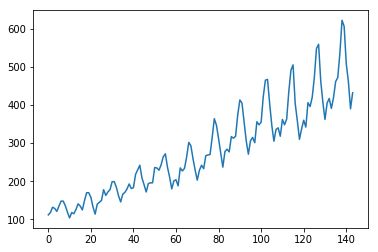

In [29]:
plt.plot(data_csv)

In [30]:
# 数据预处理
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))  #先归一化

#### 我们可以将前两个月的流量当做输入，当月的流量当做输出

In [14]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [15]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [16]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

##### RNN 读入的数据维度是 (seq, batch, feature)
这里只有一个序列，所以 batch 是 1
而输入的 feature 就是我们希望依据的几个月份，这里我们定的是两个月份，所以 feature 就是 2.

In [17]:
123月输入，4月输出 
然后567月输入，8输出吗

SyntaxError: invalid character in identifier (<ipython-input-17-80ad503e58f1>, line 1)

In [32]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

train_x.shape,train_y.shape

(torch.Size([99, 1, 2]), torch.Size([99, 1, 1]))

In [19]:
from torch import nn
from torch.autograd import Variable

##### 这里定义好模型，模型的第一部分是一个两层的 RNN，
每一步模型接受两个月的输入作为特征，得到一个输出特征。
接着通过一个线性层将 RNN 的输出回归到流量的具体数值，这里我们需要用 view 来重新排列，
因为 nn.Linear 不接受三维的输入，所以我们先将前两维合并在一起，然后经过线性层之后再将其分开，最后输出结果。

In [20]:
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [21]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

#### 定义好网络结构，输入的维度是 2，因为我们使用两个月的流量作为输入，隐藏层的维度可以任意指定，这里我们选的 4

In [33]:
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    
    print(var_x.shape,var_y.shape)
    out = net(var_x)
    print(out.shape)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size([99, 1, 1])
torch.Size([99, 1, 1])
torch.Size([99, 1, 2]) torch.Size(

KeyboardInterrupt: 

In [23]:
net = net.eval() # 转换成测试模式

In [24]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果

In [25]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

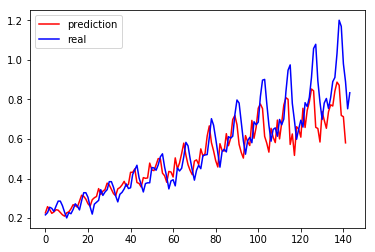

In [26]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')